This code is a 1D test with the time dependent example given in https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html . 
<br> We use her Pytorch (because most used to it ) and we observe the evolution of the solution, especially if it gives the analytical solution $u(x, t) = e^{-t}sin(\pi x)$.

### Import of deepxde and loading of pytorch

In [1]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [2]:
#TIme dependent example of the presentation
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import torch

In [3]:
# Check if CUDA (GPU) is available and set default tensor type to cuda, but I haven't installed cuda yet
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device('cuda')
    print("/////////////////\n Tensors type on GPU \n///////////////")
else:
    device = torch.device('cpu')
    print("/////////////////\n Tensors type on CPU \n///////////////")

/////////////////
 Tensors type on GPU 
///////////////


c:\Users\Bilal_BM_user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [4]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr

from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


### Domain, and Problem definition. Analytical solution (if there's one)

In [5]:
##Geometry 
sin = torch.sin
cos = torch.cos

length_factor_x = 1
length_factor_y = 1
end_time = 1

Lx = 1*length_factor_x
Ly = 1*length_factor_y

x_min = -Lx/2
x_max = Lx/2
y_min = -Ly/2
y_max = Ly/2

# geom = dde.geometry.Rectangle([0, 0], [Lx, Ly])
geom = dde.geometry.Rectangle([x_min, y_min], [x_max, y_max])
timedomain = dde.geometry.TimeDomain(0, end_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

source_val = 100
D = 0.00625
u = np.array([1, 0])
source_box_width = 1/20

In [6]:
# #Source places
position_source = torch.tensor([0., 0.], dtype=torch.float) #float type otherwise it raises an error
disc_thres = 1 #To manage the discontinuity at the source border, we take anchor points in and around the source.

source_points = dde.geometry.Rectangle((position_source - torch.ones(2)*source_box_width*disc_thres).cpu().numpy()
                                       , (position_source + torch.ones(2)*source_box_width*disc_thres).cpu().numpy()).uniform_points(int(10*10*disc_thres**2))
time_points = timedomain.uniform_points(51)
# source_points_time = np.c_[np.tile(source_points, 50), time_points]
source_points_time = np.array([[x[0],x[1], t[0]] for x in source_points for t in time_points])
# print(source_points_time)

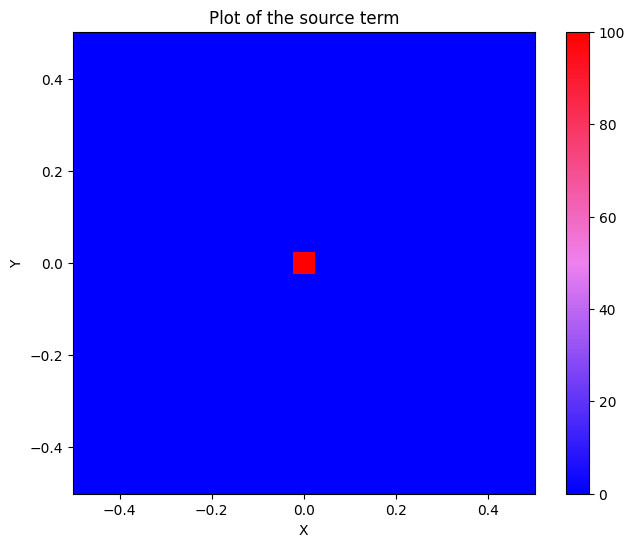

In [7]:
# #The definition of the sources and plot of them



# #Some functions to use for the source term
# def close_to_source(p, position, width):
#     '''position: Position of the middle of the source
#         width: width of the source'''
#     return (torch.isclose(p[:, 0], position[0], atol=width, rtol=0) * torch.isclose(p[:, 1], position[1], atol=width, rtol=0)).view((-1, 1))



def close_to_source_norm(p, position, width, norm):
    '''position: Position of the middle of the source
        width: width of the source'
        norm: order of the L_q norm. input is np.inf to have the infinite norm.
        (https://pytorch.org/docs/stable/generated/torch.linalg.vector_norm.html#torch.linalg.vector_norm)'''
    # print(type(p))
    p = p[:, 0:2]
    # print(p.device)
    if not isinstance(p, torch.Tensor):
        p = torch.from_numpy(p)
    p.to(device)
    distance_tensor = torch.linalg.vector_norm(p - position, ord=norm, dim=1)
    return torch.isclose(distance_tensor, torch.zeros(1, dtype=torch.float), atol=source_box_width/2, rtol=0).view((-1, 1))




# #The source_term
def source_term_func(p):
    return  source_val* close_to_source_norm(p, position_source, width=source_box_width, norm=np.inf)

# def source_term_func(p):
#     Square_middle = torch.tensor([0.5, 0.5], dtype=torch.float)
#     return (torch.isclose(p[:, 0], Square_middle[0], atol=1/10, rtol=0) * torch.isclose(p[:, 1], Square_middle[1], atol=1/10, rtol=0)).view((-1, 1))



#Plot of the Source
x = geom.uniform_points(250 * 250, True)
y_norm = source_term_func(torch.tensor(x)).cpu()



def plot_routine(plot_values, title):
    resolution_mesh = 250
    xi = np.linspace(x_min, x_max, resolution_mesh)
    yi = np.linspace(y_min, y_max, resolution_mesh)
    xi, yi = np.meshgrid(xi, yi)

    zi = griddata(points=(x[:, 0], x[:, 1]), values=plot_values[:, 0], xi=(xi, yi), method="linear")


    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "", ["blue", "violet", "red"]
    )
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

    plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to have a rectangular plot
    plt.show()


plot_routine(y_norm, "Plot of the source term")


    

In [8]:
#Residual of the Pde and IC&BC.

def pde(p, C):
    """residual of the pde
    p contains the spatial coordinates x, y and the time t
    the i-th point (xi, yi, ti) is stored in p in the i-th line and we have
    p[i, 0] = xi; p[i, 1] = yi; p[i, 2] = ti
    C corresponds to C(p) the concentration at p"""

    dC_x = dde.grad.jacobian(C, p, j=0)
    dC_y = dde.grad.jacobian(C, p, j=1)
    dC_t = dde.grad.jacobian(C, p, j=2)

    dC_xx = dde.grad.hessian(C, p, i=0, j=0)
    dC_yy = dde.grad.hessian(C, p, i=1, j=1)



 
    return (
        - dC_t
        - u[0] * dC_x
        - u[1] * dC_y
        + D * (dC_xx + dC_yy)  
        + source_term_func(p)
    )



#Conditions (Boudary & Initial)

def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)


def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], Lx)


def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], Ly)


def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)


def boundary_time(x, on_initial):
    # print(x)
    return on_initial and dde.utils.isclose(x[2], 0.0)




C_top_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_top)
C_bottom_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_bottom)
C_left_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_left)
C_right_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_right)
initial_condition = dde.icbc.IC(geomtime, lambda x:0, boundary_time)
# initial_condition = dde.icbc.IC(geomtime, source_term_func , boundary_time)



In [9]:
# '''Analytical Solution of the advection-diffusion problem (from the ANACS book)'''
# lower_limit_x = position_source[0] - source_box_width / 2
# upper_limit_x = position_source[0] + source_box_width / 2
# lower_limit_y = position_source[1] - source_box_width / 2
# upper_limit_y = position_source[1] + source_box_width / 2

# # def analytical_sol(p):
# #     x, y, t = p
# #     # f = lambda tau, v, u: S /(4*np.pi*D*(t-tau))*np.exp(-((x-u)**2 + (y-v)**2)/(4*D*(t-tau)))
# #     f = lambda y_, x_: np.exp(-((x-x_)**2 + (y-y_)**2)/(4*D*(t)))
# #     return (4*np.pi*t)*scipy.integrate.dblquad(f, pos_x_1, pos_x_2, pos_y_1, pos_y_2)[0]

# def gaussian_source(tau, v, u, x, y, t):
#     return Source_val / (4 * np.pi * D * (t - tau)) * np.exp(-((x-u)**2 + (y-v)**2) / (4 * D * (t - tau)))

# def analytical_sol(p):
#   x, y, t = p
#   f = lambda tau, v, u: Source_val / (4 * np.pi * D * (t - tau)) * np.exp(- ((x-u)**2 + (y-v)**2) / (4 * D * (t - tau)))
#   return scipy.integrate.tplquad(f, lower_limit_x, upper_limit_x, lower_limit_y, upper_limit_y, 0, t)[0]

# # def analytical_sol(p):
# #     x, y, t = p
# #     return scipy.integrate.tplquad(gaussian_source, lower_limit_x, upper_limit_x, lower_limit_y, upper_limit_y, 0, t, args=(x, y, t))[0]





In [10]:
# import time
# mean_time = 0
# N = 100
# for k in range(N):
#     start = time.time()
#     analytical_sol([0.5, 0.3, 0.7])
#     end = time.time()
#     mean_time+=(end - start)*10000/60

# mean_time = mean_time/(N)
# print(mean_time)


### **Model implementation, hyperparameter optimization**

Some **documentation for the TimePDE**: https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html#deepxde.data.pde.PDE  .
Go check the deepxde.data.pde module and then, timepde (cf link column on the site). One can e.g set a specific initialization of points (train_distribution parameter).

We call this model **"model print"** as it will be the one printed by default if there isn't any hyperparameter research 

In [11]:
opti_hyperparametre= False
already_in_memory = False
make_model = True
time_split = False
do_RAR = False

In [12]:
#Data and model:
nb_x_train =20
nb_t_train = 10
nb_x_test = 50
nb_t_test = 20

data = dde.data.TimePDE(
    geomtime,
    pde,
    [
    initial_condition,
    # C_top_bc,
    # C_bottom_bc,
    # C_left_bc,
    # C_right_bc
    ],
    num_initial=nb_x_train**2,
    num_domain=nb_x_train**2*nb_t_train,
    num_test=nb_x_test**2*nb_t_test, #uniformly generated. We have overall num_initial + num_test test points
    train_distribution='Hammersley',
    # anchors=source_points_time
)

layers = [3] + [40] *3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.pytorch.FNN(layers, activation, initializer)
model_print = dde.Model(data, net)


In [13]:

    # num_domain=500,
    # # num_boundary=500,
    # num_initial = 600,
    # num_test=1000,
    
    # num_domain=3000,
    # num_initial = 2000,
    # num_test=2000,

In [14]:
print("nb_train = ", nb_x_train**2*nb_t_train )
print("nb_initial:", nb_x_train**2)
print("nb_test:",nb_x_test**2*nb_t_test )

nb_train =  4000
nb_initial: 400
nb_test: 50000


In [15]:
arr = data.test_points()[:, 2] 
print(arr.shape)

print(data.test_points  ) 

(50800,)
<bound method PDE.test_points of <deepxde.data.pde.TimePDE object at 0x00000289264C6990>>


#### Grid search of hyperparameters

In [16]:
def create_model(config):
    '''config = [nb_x_train, nb_t_train]'''
    # learning_rate, num_dense_layers, num_dense_nodes, activation = config
    nb_x_train, nb_t_train = config
    nb_x_test, nb_t_test = 100, 20
    PDE_weight, IC_weight, BC_weight = 1, 1, 1

    d=2
    learning_rate = 1e-3

    data = dde.data.TimePDE(
        geometryxtime=geomtime,
        pde=pde,
        ic_bcs=[
            initial_condition,
            # C_top_bc,
            # C_bottom_bc,
            # C_left_bc,
            # C_right_bc
                ],
        train_distribution='Hammersley',
        
        num_initial=nb_x_train,
        num_domain=nb_x_train**d*nb_t_train,
        num_boundary=4*nb_x_train*nb_t_train,
        num_test=nb_x_test**d*nb_t_test,
    )


    layer_size = [3] + [40] *3 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layer_size, activation, initializer)

    model = dde.Model(data, net)
    model.compile("adam", lr=learning_rate, loss= 'MSE', loss_weights=[PDE_weight, IC_weight, BC_weight, BC_weight, BC_weight, BC_weight])
    return model

In [17]:


list_nb_x_train = [10]
list_nb_t_train = [10]

best_hyper_tuple = [0, 0]
best_lost_test = 1000
best_lost_epoch = 0
if opti_hyperparametre:
    for nb_x in list_nb_x_train:
        for nb_t in list_nb_t_train:
            model_hyper = create_model([nb_x, nb_t])
            early_stopping_best= dde.callbacks.ModelCheckpoint("Modeles_advdiff_2d/model_"+str(nb_x)+"_"+str(nb_t), verbose=1, save_better_only=True, period=5, monitor='test loss')
            early_stopping_var = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)

            losshistory, train_state = model_hyper.train(iterations=6000,  callbacks=[early_stopping_best, early_stopping_var])


            array_losstest = np.sum(np.array(losshistory.loss_test), axis=1)
            loss_test = np.min(array_losstest) #"Vrai loss" sans poids
            if loss_test < best_lost_test:
                best_lost_test = loss_test
                best_hyper_tuple = [nb_x, nb_t]
                best_lost_epoch = np.array(losshistory.steps)[np.argmin(array_losstest)]
                best_losshistory = losshistory
                
    print(best_hyper_tuple)
    print(best_lost_test)
    print(best_lost_epoch)
    print(best_losshistory)

In [18]:
#Restauration of the best model in term of Minimization of the test loss


if already_in_memory or opti_hyperparametre:
    print("Not make model")
    if  already_in_memory:
        best_hyper_tuple = [10, 10]
        model_print = create_model(best_hyper_tuple) 
        model_print.restore("Modeles_advdiff_2d/Best_model_2D/model_29-04_test.pt")
    else:
        model_print = create_model(best_hyper_tuple)
        losshistory_print = best_losshistory
        model_print.restore(
            save_path="Modeles_advdiff_2d/model_{nb_x}_{nb_t}-{nb_epoch}.pt".format(nb_x = best_hyper_tuple[0], nb_t = best_hyper_tuple[1], nb_epoch = best_lost_epoch))


#### Model compilation

Here is **the documentation of model.compile** : "https://deepxde.readthedocs.io/en/latest/modules/deepxde.html#deepxde.model.Model.compile". In the loss and loss_weights parameters, one must order the weights like this : weights for the pde, weights for each element of bcs. bcs is the ic bc list in the input of data. The weights for the bcs list is ordered the same way as bcs. 


Compiling model...
'compile' took 1.061587 s

Training model...

Step      Train loss              Test loss               Test metric
0         [3.04e+01, 5.10e-02]    [4.81e+01, 5.10e-02]    []  
1000      [7.50e-02, 2.75e-02]    [1.74e+01, 2.75e-02]    []  
2000      [1.26e-02, 1.20e-02]    [1.17e+01, 1.20e-02]    []  
3000      [6.18e-03, 6.77e-03]    [1.23e+01, 6.77e-03]    []  
4000      [3.98e-03, 4.05e-03]    [1.58e+01, 4.05e-03]    []  
5000      [2.89e-03, 2.49e-03]    [2.00e+01, 2.49e-03]    []  
6000      [2.04e-03, 1.60e-03]    [2.43e+01, 1.60e-03]    []  
7000      [4.52e-03, 1.11e-03]    [2.76e+01, 1.11e-03]    []  
8000      [1.32e-03, 8.72e-04]    [2.94e+01, 8.72e-04]    []  
9000      [3.89e-03, 7.75e-04]    [3.08e+01, 7.75e-04]    []  
10000     [9.95e-04, 5.94e-04]    [3.24e+01, 5.94e-04]    []  

Best model at step 10000:
  train loss: 1.59e-03
  test loss: 3.24e+01
  test metric: []

'train' took 100.676975 s

Saving loss history to c:\Users\Bilal_BM_user\Document

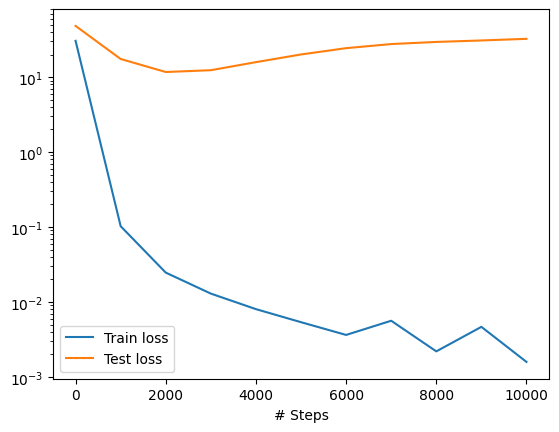

In [19]:
#Computations and graph
PDE_weight, IC_weight, BC_weight = 1, 1, 1

if make_model:
    model_print.compile("adam", lr=0.001)
    losshistory_print, train_state = model_print.train(iterations=10000)
    dde.saveplot(losshistory_print, train_state, issave=True, isplot=True)


##### **Time spliting technique**: Multiple training on different time intervals (code arnaud pr l'instant)

Here we discretize the time domain $[0,T]$ into $5$ subdomains.

In [20]:
if time_split:

    # nb_epochs = 20000
    nb_subdomains = 5
    nb_epochs = 10000 #Number of epochs for each sub model's training
    # x = geom.uniform_points(500 * 500, True)

    


    data_0 = dde.data.TimePDE(
        dde.geometry.GeometryXTime(geom, dde.geometry.TimeDomain(0, end_time/nb_subdomains)),
        pde,
        [
        initial_condition,
        ],
        num_initial=nb_x_train**2,
        num_domain=nb_x_train**2*nb_t_train,
        num_test=nb_x_test**2*nb_t_test, #uniformly generated. We have overall num_initial + num_test test points
        train_distribution='Hammersley',
    )

    layers = [3] + [40] * 5 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layers, activation, initializer)
    list_models = [dde.Model(data_0, net)]

    list_models[0].compile("adam", lr=1e-3)
    losshistory_print, train_state = list_models[0].train(epochs=nb_epochs)
    list_losshistory = [losshistory_print]
    list_train_state = [train_state]

    for k in range(1, nb_subdomains):
        data_k = dde.data.TimePDE(
            dde.geometry.GeometryXTime(geom, dde.geometry.TimeDomain(end_time/nb_subdomains*k, end_time/nb_subdomains*(k+1))),
            pde,
            [
            dde.icbc.IC(geomtime, lambda x: list_models[k-1].predict(x[:,0:2]), lambda _, on_initial: on_initial),
            ],
             num_initial=nb_x_train**2,
            num_domain=nb_x_train**2*nb_t_train,
            num_test=nb_x_test**2*nb_t_test, #uniformly generated. We have overall num_initial + num_test test points
            train_distribution='Hammersley',
        )

        list_models.append(dde.Model(data_0, net))

        list_models[k].compile("adam", lr=1e-3)
        loss_hist_k, train_state_k = list_models[k].train(epochs=nb_epochs)
        list_losshistory.append(loss_hist_k)
        list_train_state.append(train_state_k)

##### **RAR Method**

In [21]:
X = geomtime.random_points(100000)
err = 1000
print(X.shape)

(100000, 3)


In [22]:
# a_test = np.linspace(1, 1000, 1000)
# top_idx =   np.argsort(a_test)[-50:]
# print(top_idx)

In [23]:
threshold = 0.005
nb_indices = 100
iteration_total = 0
it_max = 50000 #It will be printed the total iteration so 60000 as there was 10000 iterations before

if do_RAR:
    while (iteration_total <= it_max) and (err > threshold):
        print(iteration_total)
        f = model_print.predict(X, operator=pde)
        err_eq = np.absolute(f)
        err = np.mean(err_eq)
        # print(err)
        print("Mean residual: %.3e" % (err))
        print(err_eq.shape)
        
        x_id = np.argsort(err_eq[:,0])[ -nb_indices:] #Keeps the nb_indices points that maximizes the residual
        print("Adding new points:", X[x_id], "\n")
        data.add_anchors(X[x_id])
        early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)

        model_print.compile("adam", lr=1e-3)
        losshistory, train_state= model_print.train(iterations=4000, disregard_previous_best=True, callbacks=[early_stopping])
        iteration_total+=4000
        # model.compile("L-BFGS")
        # losshistory, train_state = model.train()

### **Visualisation of the losses**

In [24]:
print_loss = True

In [25]:
if time_split:
    losshistory_print= list_losshistory[2]

In [26]:
print(" MODEL PRINT IS THE MODEL COMPUTED WITH THE HYPERPARAMETERS RESEARCH: ", opti_hyperparametre)
print(" MODEL PRINT IS THE MODEL COMPUTED AT THE BEGINNING OF THE CODE: ", not(opti_hyperparametre))
print(" MODEL PRINT IS THE MODEL COMPUTED with Time split: ", time_split)

 MODEL PRINT IS THE MODEL COMPUTED WITH THE HYPERPARAMETERS RESEARCH:  False
 MODEL PRINT IS THE MODEL COMPUTED AT THE BEGINNING OF THE CODE:  True
 MODEL PRINT IS THE MODEL COMPUTED with Time split:  False


Train Losses and Test Losses. The IC (and BC) losses for the train and test are the same as they have the same sampling points (idk why).

In [27]:
A = np.array([1, 0,5 ,2 ,5 ])
A[2:]

array([5, 2, 5])

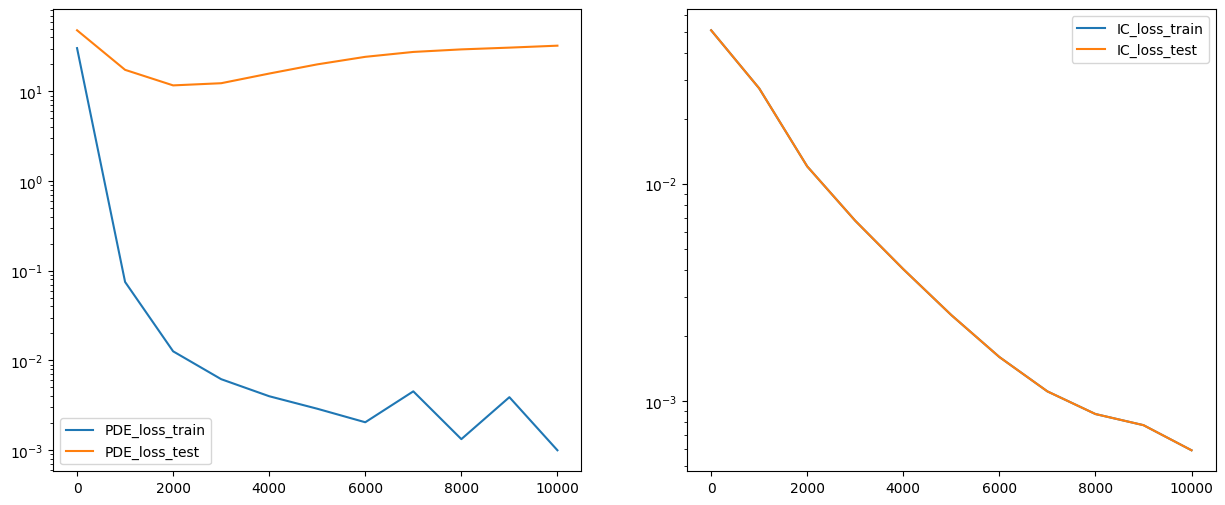

In [28]:
if print_loss:
    # if opti_hyperparametre: 

    array_losstrain = np.array(losshistory_print.loss_train)
    array_losstest = np.array(losshistory_print.loss_test)
    nb_step = np.array(losshistory_print.steps)

    PDE_loss_train = array_losstrain[:, 0]
    IC_loss_train = array_losstrain[:, 1]
    # BC_loss_train = np.sum(array_losstrain[:, 2:], axis=1) #ONE OF THE BC CONDITIONS. Its symetric so we consider just one 

    PDE_loss_test = array_losstest[:, 0]
    IC_loss_test = array_losstest[:, 1]
    # BC_loss_test = np.sum(array_losstest[:, 2:], axis=1) #Same as above

    fig, axs = plt.subplots(1, 2, figsize= (15, 6))
    for i in range(2):
        axs[i].set_yscale('log')


    axs[0].plot(nb_step, PDE_loss_train, label="PDE_loss_train")
    # axs[1].plot(nb_step, BC_loss_train, label="BC_loss_train")
    axs[1].plot(nb_step, IC_loss_train, label="IC_loss_train")

    axs[0].plot(nb_step, PDE_loss_test, label="PDE_loss_test")
    # axs[1].plot(nb_step, BC_loss_test, label="BC_loss_test")
    axs[1].plot(nb_step, IC_loss_test, label="IC_loss_test")

    for i in range(2):
        axs[i].legend()

    plt.legend()
    plt.show()


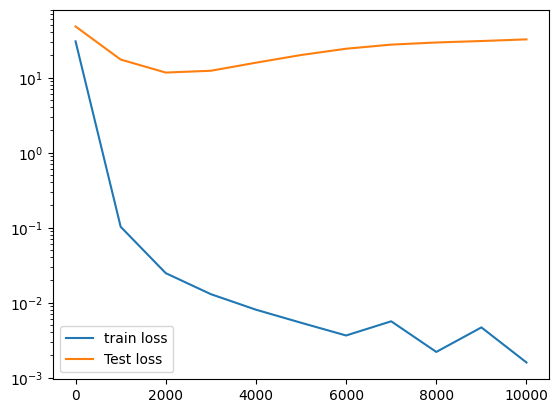

In [29]:
if print_loss:
    if False:
        Train_loss = PDE_weight*PDE_loss_train + BC_weight* BC_loss_train + IC_weight*IC_loss_train
        Test_loss = PDE_weight* PDE_loss_test + BC_weight* BC_loss_test + IC_weight*IC_loss_test
    else:
        Train_loss = PDE_loss_train  + IC_loss_train #+ BC_loss_train
        Test_loss = PDE_loss_test  + IC_loss_test #+ BC_loss_test
        
    plt.plot(nb_step, Train_loss, label="train loss")
    plt.plot(nb_step, Test_loss, label="Test loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

Little difference between the plot above and the plot below. I don't know why. Normaly, they should be equal as written in the saveplot implementation: https://deepxde.readthedocs.io/en/latest/_modules/deepxde/utils/external.html#saveplot

### **Computation, Plot and error of the solutions**

In [42]:
print(" MODEL PRINT IS THE MODEL COMPUTED WITH THE HYPERPARAMETERS RESEARCH: ", opti_hyperparametre)
print(" MODEL PRINT IS THE MODEL COMPUTED AT THE BEGINNING OF THE CODE: ", not(opti_hyperparametre))
print(" IT'S A LIST OF MODELS : ", time_split)

 MODEL PRINT IS THE MODEL COMPUTED WITH THE HYPERPARAMETERS RESEARCH:  False
 MODEL PRINT IS THE MODEL COMPUTED AT THE BEGINNING OF THE CODE:  True
 IT'S A LIST OF MODELS :  False


In [43]:

resolution_mesh_x = 251
resolution_mesh_y = 251

x_lign = np.linspace(x_min, x_max, resolution_mesh_x)
y_lign = np.linspace(y_min, y_max, resolution_mesh_y)
x = np.array( [ [x, y] for x in x_lign for y in y_lign])
xi, yi = np.meshgrid(x_lign, y_lign)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)

#### **Analytical solution or Finite Volume Solution**

In [44]:
use_of_FV = True
use_of_anal_sol = False

Some Matplotlib link for placing colorbars: https://matplotlib.org/stable/users/explain/axes/colorbar_placement.html

##### Analytical Solution (if there is one)

In [45]:
if use_of_anal_sol: 
    #Analytical solution computation
    # time_list = [0, 0.3, 0.7, 1.]


    batch_size = 50
    a_t1 = np.zeros(len(p_1))
    a_t2 = np.zeros(len(p_2))
    a_t3 = np.zeros(len(p_3))
    a_t4 = np.zeros(len(p_4))
    counter_batch = 0

    for i in range(0, len(p_2), batch_size):
        print( "batch n", counter_batch)
        start = time.time()
        batch_points = p_2[i:i+batch_size]
        a_t2[i:i+batch_size] = np.apply_along_axis(analytical_sol, axis=1, arr=batch_points)
        end = time.time()
        counter_batch += 1
        print("Time per batch: ", (end-start))

    np.save("Modeles_advdiff_2d/saved_arrays/array_save_time_3.npy", arr=a_t2)


In [46]:
if use_of_anal_sol:
    loaded_array = np.load("Modeles_advdiff_2d/saved_arrays/array_save.npy")
    print(loaded_array)

##### Finite Volume Solution

In [47]:
if use_of_FV:
    dataset_FV = xr.open_dataset("simulation.nc")
    print(dataset_FV)
    print("\n")
    print(dataset_FV.dims)

<xarray.Dataset> Size: 125MB
Dimensions:      (time: 99, z: 1, y: 251, x: 251)
Dimensions without coordinates: time, z, y, x
Data variables:
    scalar1      (time, z, y, x) float32 25MB ...
    AOD_scalar1  (time, y, x) float32 25MB ...
    Ux           (time, z, y, x) float32 25MB ...
    Uy           (time, z, y, x) float32 25MB ...
    Uz           (time, z, y, x) float32 25MB ...


FrozenMappingWarningOnValuesAccess({'time': 99, 'z': 1, 'y': 251, 'x': 251})


In [48]:
if use_of_FV:  

    
    FV_dataarray = dataset_FV.data_vars['scalar1']
    FV_np_array = FV_dataarray.to_numpy()
    print(np.nanmax(FV_np_array))
    nan_arr = np.isnan(FV_np_array)
    num_nan = np.sum(nan_arr)
    print("Proportion of nan elements: ", num_nan/np.size(FV_np_array))

    #Convertion without nans 
    FV_np_array = np.nan_to_num(FV_np_array, nan=0)
    print(np.max(FV_np_array))

    #DIMENSIONS : time; z: 1; y: ; x: 
    print(FV_np_array.shape)
    FV_np_array = FV_np_array[:, 0, :, :]
    print(FV_np_array.shape)
    print(FV_np_array[0])



3.4959288
Proportion of nan elements:  1.5872763924382153e-05
3.4959288
(99, 1, 251, 251)
(99, 251, 251)
[[-2.8937321e-34 -8.3992203e-34 -1.6337019e-33 ...  5.2102006e-08
   5.3631464e-08  5.4565305e-08]
 [-2.9726310e-34 -8.8242901e-34 -1.7391779e-33 ...  5.5717475e-08
   5.7379189e-08  5.8602573e-08]
 [-3.2864182e-34 -9.7811471e-34 -1.9412892e-33 ...  6.1834811e-08
   6.3717088e-08  6.5518726e-08]
 ...
 [-2.9334574e-34 -8.7175056e-34 -1.7169065e-33 ...  5.5012219e-08
   5.6240474e-08  5.7993855e-08]
 [-2.7724881e-34 -8.2402218e-34 -1.6123176e-33 ...  5.2010993e-08
   5.4071137e-08  5.4849167e-08]
 [-3.8712693e-34 -9.3460084e-34 -1.7842540e-33 ...  5.0641741e-08
   5.3037986e-08  0.0000000e+00]]


Text(0.5, 1.0, 't = 2')

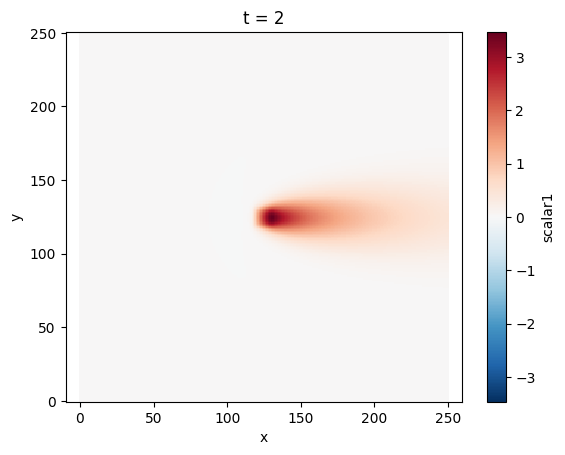

In [49]:
FV_dataarray[0, :, :].plot()
plt.axis('equal')
plt.title("t = 2")

In [50]:
#Watch out: [t, y, x]
# print(FV_np_array[0, 50, :])

#### **Fixed time: plots of solutions, visualization of the errors.**

##### Plots and error for a fixed given time

In [86]:
x.shape

(63001, 2)

In [87]:
start_time_simu = 0.5
step_time_simu = 0.25
nb_time_simu = 99

FV_times = start_time_simu + np.arange(0, nb_time_simu) * step_time_simu
print(FV_times)

[ 0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25
  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75  6.    6.25
  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75  9.    9.25
  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75 12.   12.25
 12.5  12.75 13.   13.25 13.5  13.75 14.   14.25 14.5  14.75 15.   15.25
 15.5  15.75 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75 18.   18.25
 18.5  18.75 19.   19.25 19.5  19.75 20.   20.25 20.5  20.75 21.   21.25
 21.5  21.75 22.   22.25 22.5  22.75 23.   23.25 23.5  23.75 24.   24.25
 24.5  24.75 25.  ]


In [88]:
Use_max = False
C_max = 0.7 #Max in absolute value to scale the color of the graph

t_1_idx = 2
t_1 = FV_times[t_1_idx] #WATCH OUT to the FV time discretization.  
print("TIME : ", t_1)
p = np.c_[x, np.array([t_1] * x.shape[0])]
print("Number of points :", p.shape[0])


#Analytical or Finite Volume solution
if use_of_anal_sol:
    print("Analytical sol not implemented") 
elif use_of_FV:
    C_s = FV_np_array[t_1_idx, :, :] #Concentration  which is the solution 
    C_s = C_s.T.flatten()
else: 
    print("Problem: no solution method chosen. ")

# Prediction of the model
if time_split: 
    C_p = list_models[0].predict(p)[:,0] #Concentraion which is predicted by the model
else: 
    C_p = model_print.predict(p)[:,0]
print(C_p.shape)



TIME :  1.0
Number of points : 63001
(63001,)


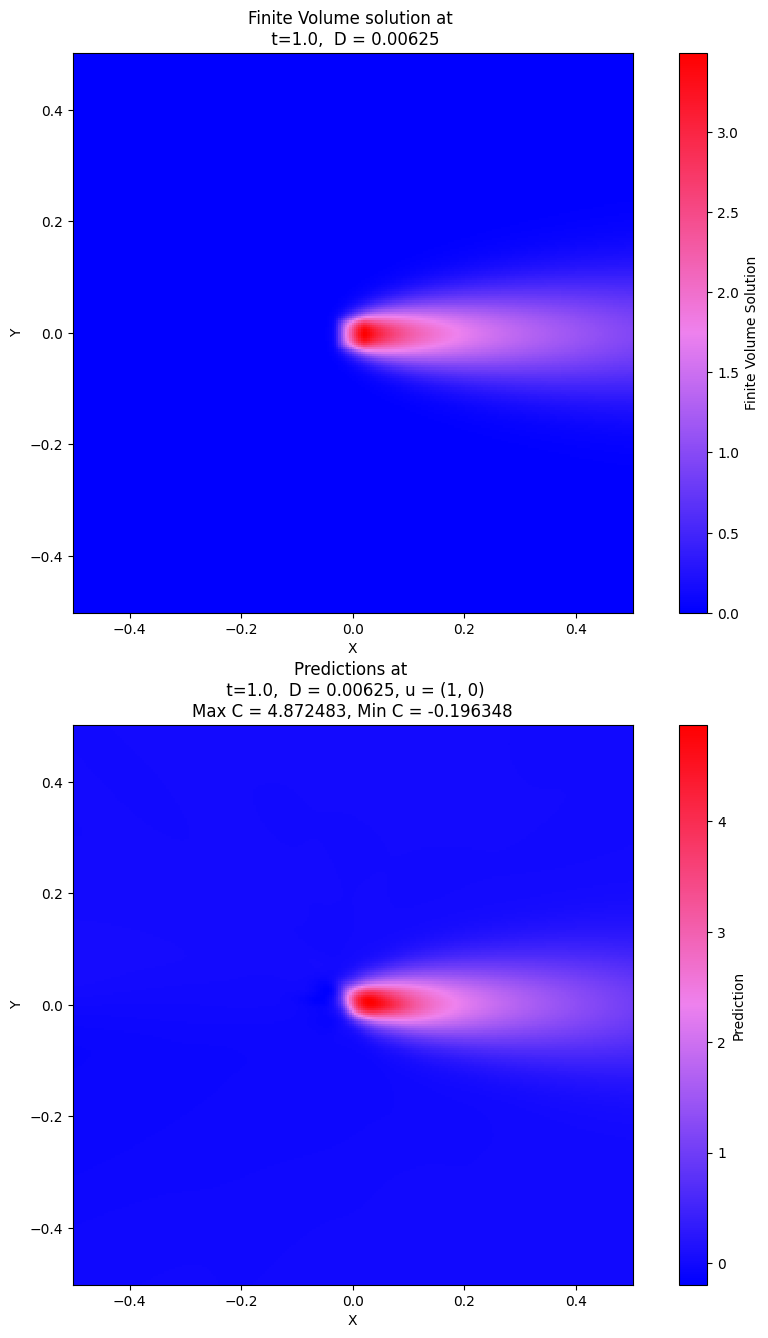

<Figure size 640x480 with 0 Axes>

In [89]:
#Plot of analytical or FE computed solution and PINNs computed solution

Only_positive = False #Plot the positive part of the computed solution


# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 16))
# fig, axs = plt.subplots(2, 1, gridspec_kw={'width_ratios': [2, 1]})

if Only_positive:
    zi = griddata((x[:, 0], x[:, 1]), C_p*(C_p>0), (xi, yi), method="linear")
else:
    zi = griddata((x[:, 0], x[:, 1]), C_p, (xi, yi), method="linear")
zi_s = griddata((x[:, 0], x[:, 1]), C_s, (xi, yi), method="linear")

plt.figure()


#Set the Colorbar scale
if Use_max:
    ax_0_pcolormesh = axs[0].pcolormesh(xi, yi, zi_s, cmap=cmap, vmin=-1*C_max, vmax=C_max, shading="auto")
    ax_1_pcolormesh = axs[1].pcolormesh(xi, yi, zi, cmap=cmap, vmin=-1*C_max, vmax=C_max, shading="auto")
else:
    ax_0_pcolormesh = axs[0].pcolormesh(xi, yi, zi_s, cmap=cmap, shading="auto")
    ax_1_pcolormesh = axs[1].pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
    
if use_of_anal_sol:
    fig.colorbar(ax_0_pcolormesh, label="Analytical solution")
elif use_of_FV:
    fig.colorbar(ax_0_pcolormesh, label="Finite Volume Solution")
fig.colorbar(ax_1_pcolormesh, label="Prediction")


#Setting of axis and graph titles
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")

if use_of_anal_sol:
    title_plot_0 = "Analytical solution " + "at \n t={time},  D = {Diffusion}"
elif use_of_FV:
    title_plot_0 = "Finite Volume solution " + "at \n t={time},  D = {Diffusion}"
title_plot = "Predictions " + "at \n t={time},  D = {Diffusion}, u = ({u_x}, {u_y})\n" + "Max C = {max}, Min C = {min}"

axs[0].set_title(title_plot_0.format(time=t_1, Diffusion = D))
axs[1].set_title(title_plot.format(time=t_1, Diffusion = D, u_x=u[0], u_y=u[1], max = int(np.max(C_p)*10e5)/10e5, min = int(np.min(C_p)*10e5)/10e5))



axs[0].set_aspect('equal')
axs[1].set_aspect('equal')


#plot
# plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to have a rectangular plot
# plt.close()
plt.show()


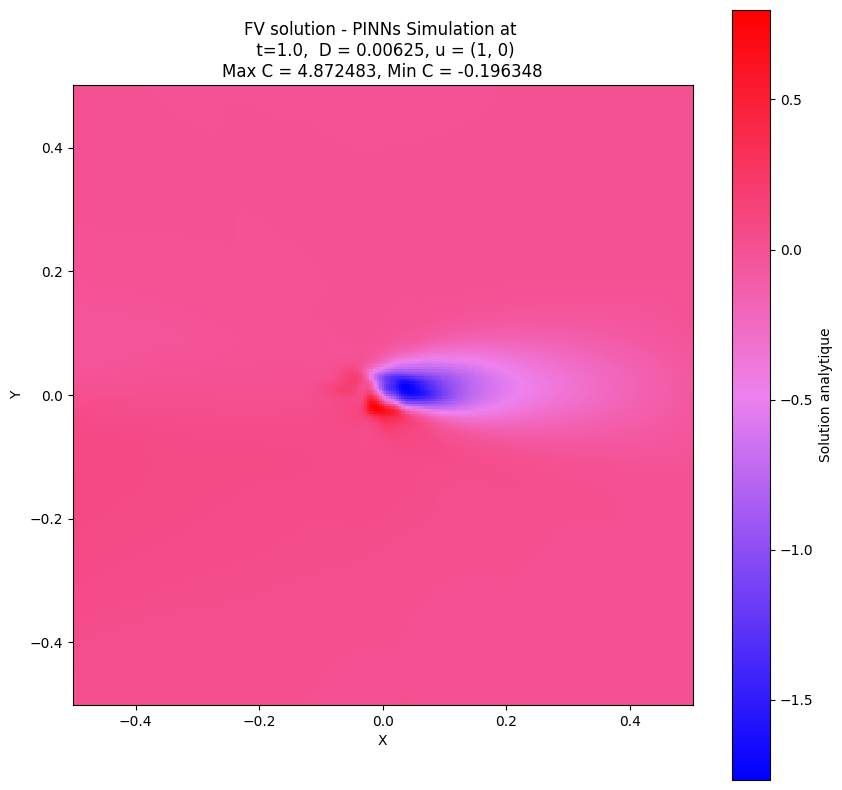

<Figure size 640x480 with 0 Axes>

In [90]:
#Difference plot

Only_positive = False #Plot the positive part of the computed solution


# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 10))


zi_d = griddata((x[:, 0], x[:, 1]), C_s-C_p, (xi, yi), method="linear")

plt.figure()


#Set the Colorbar scale
if Use_max:
    ax_0_pcolormesh = ax.pcolormesh(xi, yi, zi_d, cmap=cmap, vmin=-1*C_max, vmax=C_max, shading="auto")
else:
    ax_0_pcolormesh = ax.pcolormesh(xi, yi, zi_d, cmap=cmap, shading="auto")
    
    
fig.colorbar(ax_0_pcolormesh, label="Solution analytique")



#Setting of axis and graph titles
ax.set_xlabel("X")
ax.set_ylabel("Y")

if use_of_anal_sol:
    title_plot = "Analytical solution - PINNS Simulation " + "at \n t={time},  D = {Diffusion}"
elif use_of_FV:
    title_plot = "FV solution - PINNs Simulation " + "at \n t={time},  D = {Diffusion}, u = ({u_x}, {u_y})\n" + "Max C = {max}, Min C = {min}"
# title_plot = "Predictions " + "at \n t={time},  D = {Diffusion}, u = ({u_x}, {u_y})\n" + "Max C = {max}, Min C = {min}"

# axs[0].set_title(title_plot_0.format(time=t_1, Diffusion = D))
ax.set_title(title_plot.format(time=t_1, Diffusion = D, u_x=u[0], u_y=u[1], max = int(np.max(C_p)*10e5)/10e5, min = int(np.min(C_p)*10e5)/10e5))



ax.set_aspect('equal')


#plot
# plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to have a rectangular plot
# plt.close()
plt.show()


In [92]:
'''L2 difference computation'''
# space_step = 100
# x_err = geom.uniform_points(space_step**2, boundary=True)
x_err = x #= np.array( [ [x, y] for x in x_lign for y in y_lign])

error= dde.metrics.l2_relative_error(C_s, C_p) 
print("\nDeepXDE-made relative error: ", 100*error, "%")

#Hand-made verifications
error_hand_made = np.linalg.norm(C_s-C_p)/np.linalg.norm(C_s) #default 2-norm
print("\nHand-made relative error ", 100*error_hand_made, "%")


DeepXDE-made relative error:  36.44557297229767 %

Hand-made relative error  36.44557297229767 %


##### Plot and error in all the time. Animations

In [55]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [111]:
# Define the time domain
# t = np.linspace(0, 1, 30)
delta_t = 0.1*end_time # time step for the animation
p = np.c_[x, np.array([0] * x.shape[0])]


# Initialize the figure and subplots. Computes the initial functions to have a beginning point for the simulation
fig, axs = plt.subplots(2, 1, figsize=(16, 16))
if time_split:
    C_p_anim = list_models[0].predict(p)[:,0]
else:
    C_p_anim = model_print.predict(p)[:, 0]

if use_of_anal_sol:
    print("Analytic solution not implemented")
elif use_of_FV:
    C_s_anim = FV_np_array[0, :, :].T.flatten()
else: 
    print("Problem: no solution method chosen. ")

print(C_p_anim.shape)
print(C_s_anim.shape)

#initiliaze the grid point values, the colormeshes and their labels
zi_p = griddata((x[:, 0], x[:, 1]), C_p_anim, (xi, yi), method="linear")
zi_s = griddata((x[:, 0], x[:, 1]), C_s_anim, (xi, yi), method="linear")

pcolormesh_s = axs[0].pcolormesh(xi, yi, zi_s, cmap=cmap, shading="auto")
pcolormesh_p = axs[1].pcolormesh(xi, yi, zi_p, cmap=cmap, shading="auto")

axs[0].set_aspect('equal')
axs[1].set_aspect('equal')

fig.colorbar(pcolormesh_s, label="Solution analytique")
fig.colorbar(pcolormesh_p, label="Prédiction")


# Update function for the animation
def update(frame):
    #Two graphs
    # t_1 = t[frame]
    t_1 = delta_t*frame + start_time_simu
    
    p = np.c_[x, np.array([t_1] * x.shape[0])]
    if time_split:
        # model_id = int(np.clip(t_1 // (end_time//nb_subdomains), 0, nb_subdomains-1)) # which model to take
        model_id = int(np.clip(t_1 / (end_time/nb_subdomains), 0, nb_subdomains-1))
        C_p_anim = list_models[model_id].predict(p)
    else:
        C_p_anim = model_print.predict(p)[:,0]
    C_s_anim = FV_np_array[frame, :, :].T.flatten() 
    
    zi_p = griddata((x[:, 0], x[:, 1]), C_p_anim, (xi, yi), method="linear")
    zi_s = griddata((x[:, 0], x[:, 1]), C_s_anim, (xi, yi), method="linear")
    
    axs[0].set_title('Analytical solution at time {}'.format(t_1))
    axs[1].set_title('Computed solution at time {}'.format(t_1))
    

    pcolormesh_s.set_array(zi_s.ravel())
    pcolormesh_p.set_array(zi_p.ravel())
    return pcolormesh_s, pcolormesh_p




# Create the animations
nb_frames = int(end_time//delta_t)+1
# nb_frames = int(10//delta_t)+1

animation = FuncAnimation(fig, update, frames=nb_frames) #frames make range(len(t))
plt.close() #to avoid having another plot after the animation

# Show the animation
HTML(animation.to_jshtml())

(63001,)
(63001,)


In [118]:
#Animation of the difference. 

delta_t = 0.1*end_time # time step for the animation
p = np.c_[x, np.array([start_time_simu] * x.shape[0])]


# Initialize the figure and subplots. Computes the initial functions to have a beginning point for the simulation
fig, ax = plt.subplots(1, 1, figsize=(16, 16))

if time_split:
    C_p_anim = list_models[0].predict(p)[:,0]
else:
    C_p_anim = model_print.predict(p)[:, 0]

if use_of_anal_sol:
    print("Analytic solution not implemented")
elif use_of_FV:
    C_s_anim = FV_np_array[0, :, :].T.flatten()
else: 
    print("Problem: no solution method chosen. ")



print(C_p_anim.shape)
print(C_s_anim.shape)

#initiliaze the grid point values, the colormeshes and their labels
zi_d = griddata((x[:, 0], x[:, 1]), C_s_anim-C_p_anim, (xi, yi), method="linear")

pcolormesh_d = ax.pcolormesh(xi, yi, zi_d, cmap=cmap, shading="auto")
ax.set_aspect('equal')
fig.colorbar(pcolormesh_d, label="Concentration")


# Update function for the animation
def update(frame):
    #Two graphs
    # t_1 = t[frame]
    t_1 = delta_t*frame + start_time_simu
    
    p = np.c_[x, np.array([t_1] * x.shape[0])]
    if time_split:
        # model_id = int(np.clip(t_1 // (end_time//nb_subdomains), 0, nb_subdomains-1)) # which model to take
        model_id = int(np.clip(t_1 / (end_time/nb_subdomains), 0, nb_subdomains-1))
        C_p_anim = list_models[model_id].predict(p)
    else:
        C_p_anim = model_print.predict(p)[:,0]
    C_s_anim = FV_np_array[frame, :, :].T.flatten() 
    
    griddata((x[:, 0], x[:, 1]), C_s_anim-C_p_anim, (xi, yi), method="linear")
    
    ax.set_title('FV solution - PINNs solution at time {}'.format(t_1))
    

    pcolormesh_d.set_array(zi_d.ravel())
    return pcolormesh_d,




# Create the animations
nb_frames = int(end_time//delta_t)+1
# nb_frames = int(10//delta_t)+1

animation = FuncAnimation(fig, update, frames=nb_frames) #frames make range(len(t))
plt.close() #to avoid having another plot after the animation

# Show the animation
HTML(animation.to_jshtml())

(63001,)
(63001,)


In [115]:
(C_s_anim-C_p_anim).shape

(63001,)

**Error Checks**

In [58]:
from numpy import linalg

In [100]:
x_space_time_err = np.array([[pt[0], pt[1], t] for pt in x_err for t in FV_times])
print(x_space_time_err.shape)


(6237099, 3)


In [105]:
x_space_time_err

array([[-0.5 , -0.5 ,  0.5 ],
       [-0.5 , -0.5 ,  0.75],
       [-0.5 , -0.5 ,  1.  ],
       ...,
       [ 0.5 ,  0.5 , 24.5 ],
       [ 0.5 ,  0.5 , 24.75],
       [ 0.5 ,  0.5 , 25.  ]])

In [107]:
FV_np_array[:3, :, :].shape

(3, 251, 251)

In [109]:
'''L2 difference computation'''
# space_step = 100
# time_step = 100


# x = geomtime.uniform_points(space_step**2*time_step, boundary=True)
# y_true = analytical_sol(x[:,0], x[:,1], N=500)

x_space_time_err = np.array([ [pt[0], pt[1], FV_times[k]] for pt in x_err for k in range(3) ]) #go until t=1s
print(x_space_time_err.shape)

if use_of_anal_sol:
    y_true = analytical_sol(x)
    y_pred = model_print.predict(x)[:, 0] #Watch out: shape of model.predict is  (M, 1).
elif use_of_FV: 
    y_true = np.ravel(np.transpose(FV_np_array[:3, :, :], (2, 1, 0)))
    y_pred = model_print.predict(x_space_time_err)[:, 0]
else: 
    print("No type of solution chosen.")

print(np.shape(y_pred))
print(np.shape(y_true))


error= dde.metrics.l2_relative_error(y_true, y_pred) 
# print(y_pred)
print("\nDeepXDE-made relative error: ", 100*error, "%")


#Hand-made verifications
error_hand_made = np.linalg.norm(y_true-y_pred)/np.linalg.norm(y_true) #default 2-norm
print("\nHand-made relative error ", error_hand_made*100, "%")

(189003, 3)
(189003,)
(189003,)

DeepXDE-made relative error:  29.453903436660767 %

Hand-made relative error  29.453903436660767 %
